This is the simplest diffusion model I could think of. 
It has no tricks (time embedding, positional encoding, the schedule is fixed etc.), no complex neural networks like Unet - only a simple autoencoder and the data has only 2 dimensions. 
The purpose of this code is to show the principal of the diffusion process in the most basic way. 
On top of that, if someone would like to add and devlope a more complex algorithm for a more complex data set, he'll be able to do so.
This is only a tutorial with the sole purpose of explaining the diffusion purpose and to show the most simple code example.  

In [1]:
import tensorflow as tf
import numpy as np

def glorot_init(shape):
    return tf.cast(tf.random.normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.), seed=0), dtype=tf.float64)

class DM_AE:
    def __init__(self, net_size, learning_rate, epochs, batch_size, rate, beta, num_of_steps):
        self.net_size = net_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        # Adam optimizer.
        self.optimizer = tf.optimizers.Adam(learning_rate=self.learning_rate)
        self.rate = rate
        self.weights, self.biases = self.generate_vars()
        self.num_of_steps = num_of_steps

        self.beta = beta
        self.alpha = 1 - beta
        self.alpha_bar = np.cumprod(self.alpha, 0)
        self.alpha_bar_prev = np.concatenate((np.array([1.]), self.alpha_bar[:-1]), axis=0)
        self.sqrt_alpha_bar = np.sqrt(self.alpha_bar)
        self.one_minus_sqrt_alpha_bar = np.sqrt(1 - self.alpha_bar)
        self.posterior_variance = beta * (1. - self.alpha_bar_prev) / (1. - self.alpha_bar)

    def generate_noisy_data(self, batch, num_of_steps, t):
        eps = tf.random.normal(tf.shape(batch), dtype=tf.dtypes.float64)
        noisy_batch = self.sqrt_alpha_bar[t] * batch + self.one_minus_sqrt_alpha_bar[t] * eps
        return noisy_batch, eps, t

    def generate_vars(self):
        weights = dict()
        biases = dict()
        for i in range(1, len(self.net_size)):
            weights['e' + str(i)] = tf.Variable(glorot_init([self.net_size[i - 1], self.net_size[i]]))
            weights['d' + str(i)] = tf.Variable(glorot_init([self.net_size[-i], self.net_size[-1 - i]]))
            biases['e' + str(i)] = tf.Variable(glorot_init([self.net_size[i]]))
            biases['d' + str(i)] = tf.Variable(glorot_init([self.net_size[-1 - i]]))
        return weights, biases

    #Autoemcoder
    # Building the encoder.
    def encoder(self, x, t):
        curr_layer = (1 - self.rate) * tf.nn.dropout(x, self.rate)
        for k in range(1, len(self.net_size)):
            curr_layer = tf.nn.sigmoid(tf.add(tf.matmul(curr_layer, self.weights['e' + str(k)]), self.biases['e' + str(k)]))
        return curr_layer

    # Building the decoder.
    def decoder(self, x, t):
        curr_layer = x
        for k in range(1, len(self.net_size)):
            curr_layer = 5*(-0.5+tf.nn.sigmoid(tf.add(tf.matmul(curr_layer, self.weights['d' + str(k)]), self.biases['d' + str(k)])))
        return curr_layer

    # abs square loss between original images and reconstructed ones.
    def mean_abs(self, reconstructed, original):
        return tf.reduce_mean(tf.abs(original-reconstructed))

    # Optimization process.
    def run_optimization(self, x, eps, t):
        # Wrap computation inside a GradientTape for automatic differentiation.
        with tf.GradientTape() as g:
            est_eps = self.decoder(self.encoder(x, t), t)
            loss = self.mean_abs(est_eps, eps)
        # Variables to update, i.e. trainable variables.
        trainable_variables = [[r for r in (self.weights).values()] + [r for r in (self.biases).values()]][0]
        # Compute gradients.
        gradients = g.gradient(loss, trainable_variables)
        # Update W and b following gradients.
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        return loss
    run_optimization_func = tf.function(run_optimization)

    def fit(self, train_data):
        num_of_batches = int(train_data.shape[0] / self.batch_size)
        # Run training for the given number of steps.
        for epoch in range(self.epochs):
            for batch in range(num_of_batches):
                # Run the optimization.
                batch_x = train_data[batch * self.batch_size:(batch + 1) * self.batch_size, :]
                t = tf.random.uniform([batch_x.shape[0], 1], minval=0, maxval=self.num_of_steps - 1, dtype=tf.dtypes.int64)
                batch_x, eps, t = self.generate_noisy_data(batch_x, self.num_of_steps, t)

                loss = self.run_optimization(batch_x, eps, t)
            if epoch % 10 == 0:
                print("epoch: %i, loss: %f" % (epoch, loss))

    def generate_synthethic_sample(self, shape, num_of_gen):
        img = tf.random.normal([num_of_gen, shape], dtype=tf.dtypes.float64)
        for t in list(range(self.num_of_steps))[::-1]:
            est_noise = self.decoder(self.encoder(img, t), t)
            noise = tf.random.normal([num_of_gen, shape], dtype=tf.dtypes.float64)
            img = (1/tf.sqrt(self.alpha[t]))*(img - (self.beta[t]/(self.one_minus_sqrt_alpha_bar[t]))*est_noise)+tf.sqrt(self.posterior_variance[t])*noise*self.beta[t]
        return img

2023-10-21 22:50:02.525697: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('TkAgg')
#create "swiss role" data
from sklearn.datasets import make_swiss_roll
def sample_batch(size, noise=1.0):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]]/10
data = sample_batch(10000)

timesteps = 70
# create a fixed beta schedule
beta = np.linspace(0.0001, 0.007, timesteps)

#setting parameters. These parameters work well enough to show that it works - it is possible to find better ones.
data = np.array(data,dtype='float64')
num_features = data.shape[1]
net_size = [num_features, 300, 150, 50]
learning_rate = 1e-3 
epochs = 200 
batch_size = 100
dm_ae = DM_AE(net_size, learning_rate, epochs, batch_size, 0, beta, timesteps)
dm_ae.fit(data)

2023-10-21 22:50:04.449587: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


epoch: 0, loss: 0.742937
epoch: 10, loss: 0.682175
epoch: 20, loss: 0.722705
epoch: 30, loss: 0.733742
epoch: 40, loss: 0.744524
epoch: 50, loss: 0.743354
epoch: 60, loss: 0.657444
epoch: 70, loss: 0.662219
epoch: 80, loss: 0.627855
epoch: 90, loss: 0.650090
epoch: 100, loss: 0.679402
epoch: 110, loss: 0.725331
epoch: 120, loss: 0.690523
epoch: 130, loss: 0.737211
epoch: 140, loss: 0.603642
epoch: 150, loss: 0.704504
epoch: 160, loss: 0.714049
epoch: 170, loss: 0.712631
epoch: 180, loss: 0.740933
epoch: 190, loss: 0.696535


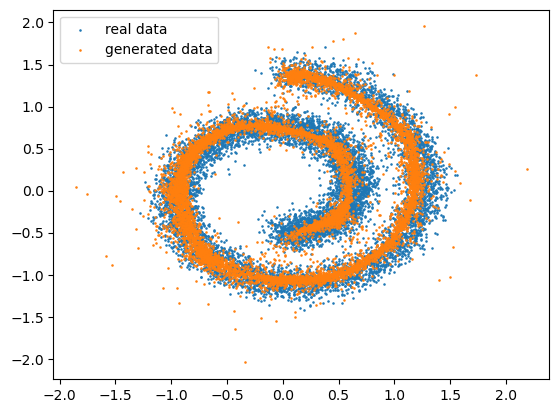

In [3]:
%matplotlib inline
gen_data = dm_ae.generate_synthethic_sample(num_features, 10000)

plt.scatter(data[:,0], data[:, 1], s=0.7, label='real data')
plt.scatter(gen_data[:,0], gen_data[:,1], s=0.7, label='generated data')
plt.legend(loc="upper left")
plt.show()